In [16]:
import json
import os
import pandas as pd

# paths you already have
json_path   = "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_06/20241015pmcr2_17_13/MIR_Aligned/frame_mapping.json"
csv_folder  = "/data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/202401015-PMC-r2/customEntValHere/2024_11_06/17_13_26"
csv_path    = os.path.join(csv_folder, "My_V4_Miniscope", "headOrientation.csv")

# 1. load JSON
with open(json_path, "r") as f:
    mapping = json.load(f)
timestamps = mapping["mini_cam_timestamps"]

# 2. load CSV
df = pd.read_csv(csv_path)

# 3. filter
df_filt = df[df["Time Stamp (ms)"].isin(timestamps)]

# 4. save filtered CSV back into MIR_Aligned
out_folder = os.path.dirname(json_path)
out_path   = os.path.join(out_folder, "headOrientation_filtered.csv")
df_filt.to_csv(out_path, index=False)

print(f"Kept {len(df_filt)} rows → saved to\n  {out_path}")



Kept 8896 rows → saved to
  /data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_06/20241015pmcr2_17_13/MIR_Aligned/headOrientation_filtered.csv


In [ ]:
# Cell 1: 准备环境
import pandas as pd
import numpy as np
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D   # noqa: F401
from matplotlib.animation import FuncAnimation
import sys, os

# Cell 2: 读数据 & 转 Rotation 对象

# "/data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/202401015-PMC-r2/customEntValHere/2024_11_06/16_57_35"
# "/data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/bno_test/customEntValHere/2025_05_09/11_00_52"
# "/data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241001PMCRE2/customEntValHere/2025_02_12/15_36_16"
# csv_folder = "/data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/202401015-PMC-r2/customEntValHere/2024_11_06/17_13_26"
# csv_path = os.path.join(csv_folder,'My_V4_Miniscope/headOrientation.csv')
csv_path = "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_06/20241015pmcr2_17_13/MIR_Aligned/headOrientation_filtered.csv"

df = pd.read_csv(csv_path)
quat = df[['qx','qy','qz','qw']].to_numpy()  # SciPy 期望 [x,y,z,w] 顺序
rots = R.from_quat(quat)                     # N 帧的 Rotation 序列
times = df['Time Stamp (ms)'].to_numpy()

# Cell 3: 定义立方体顶点和棱线
# 一个边长为 1，中心在原点的立方体
verts = np.array([
    [-0.5,-0.5,-0.5],
    [ 0.5,-0.5,-0.5],
    [ 0.5, 0.5,-0.5],
    [-0.5, 0.5,-0.5],
    [-0.5,-0.5, 0.5],
    [ 0.5,-0.5, 0.5],
    [ 0.5, 0.5, 0.5],
    [-0.5, 0.5, 0.5],
])
# 按顶点索引画出 12 条棱
edges = [
    (0,1),(1,2),(2,3),(3,0),
    (4,5),(5,6),(6,7),(7,4),
    (0,4),(1,5),(2,6),(3,7),
]

# Cell 4: 初始化 3D 画布
# fig = plt.figure(figsize=(6,6))
# ax = fig.add_subplot(111, projection='3d')
# ax.set_xlim(-1,1); ax.set_ylim(-1,1); ax.set_zlim(-1,1)
# ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
# lines = [ax.plot([],[],[], 'k-')[0] for _ in edges]

# Cell 5: 每帧更新函数
# def update_frame(i):
#     Rm = rots[i].as_matrix()  # 3×3
#     pts = verts @ Rm.T        # N×3
#     for line, (u,v) in zip(lines, edges):
#         xs, ys, zs = pts[[u,v],0], pts[[u,v],1], pts[[u,v],2]
#         line.set_data(xs, ys)
#         line.set_3d_properties(zs)
#     ax.set_title(f"t = {times[i]} ms")
#     return lines

# # Cell 6: 生成并显示动画（或保存为 MP4）
# ani = FuncAnimation(fig, update_frame, frames=len(rots),
#                     interval=10, blit=True)
# plt.close(fig)  # 防止 notebook 自动绘原点
# 要在 notebook 里直接看：
# from IPython.display import HTML
# HTML(ani.to_jshtml())

# —— 或者，保存成文件 —— 
# ani.save('bno_test_orientation_anim.mp4', dpi=200, fps=10, writer='ffmpeg')

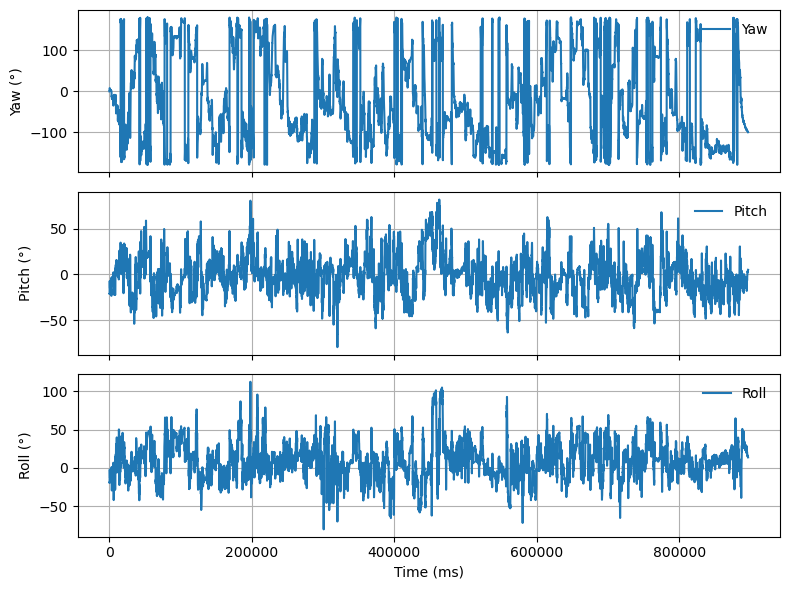

In [21]:
# Cell 7: 计算并绘制 Euler 角
# —————————————————————————————————————————————
# 1. 提取 Euler 角（°），顺序为 [yaw, pitch, roll]
euler_angles = rots.as_euler('zyx', degrees=True)  # shape (N,3)
yaw   = euler_angles[:, 0]
pitch = euler_angles[:, 1]
roll  = euler_angles[:, 2]

# 2. 绘图
fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True)
axes[0].plot(times, yaw,   label='Yaw')   # 绕 Z 轴
axes[1].plot(times, pitch, label='Pitch') # 绕 Y 轴
axes[2].plot(times, roll,  label='Roll')  # 绕 X 轴

# 3. 美化
axes[0].set_ylabel('Yaw (°)')
axes[1].set_ylabel('Pitch (°)')
axes[2].set_ylabel('Roll (°)')
axes[2].set_xlabel('Time (ms)')
for ax in axes:
    ax.grid(True)
    ax.legend(loc='upper right', frameon=False)

plt.tight_layout()
plt.show()


In [18]:
# we should align the data first, lol
from pathlib import Path

base_path = "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_06/20241015pmcr2_17_13"
# # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_06/20241015pmcr2_16_53"
# # "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_12/20241001PMCRE2mini_15_35"

aligned_dir = Path(base_path) / 'MIR_Aligned'
h5_paths = list(aligned_dir.glob('aligned_predictions_with_ca_and_dF_F_*.h5'))
if not h5_paths:
    raise FileNotFoundError(f"No .h5 files found in {aligned_dir}")

df_h5 = pd.read_hdf(str(h5_paths[0]), key='df')
# video_path = os.path.join(base_path, f'videos/Camera{cammm}/0.mp4')
# label3d_path = find_calib_file(base_path)
# pred_folder = 'DANNCE/predict00'
# pred_path = os.path.join(base_path, pred_folder, 'save_data_AVG.mat') #  smoothed_prediction_AVG0.mat


In [19]:
df_h5.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8896 entries, -51 to 896622
Columns: 152 entries, com_x to dF_F_roi40
dtypes: float64(151), int64(1)
memory usage: 10.4 MB


BNO frames: 8896
BNO rotation mats shape: (8896, 3, 3)
H5 files: [PosixPath('/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_06/20241015pmcr2_17_13/MIR_Aligned/aligned_predictions_with_ca_and_dF_F_wnd1000_stp700_max15_diff3.5_pnrauto.h5')]
Predicted frames: 8896
Head rotation mats shape: (8896, 3, 3)
Frame 0 pred pts:
 [[ -3.71953889 -14.63203413   0.59609063]
 [  3.71953889  14.63203413  -0.59609063]
 [ 21.25044992   2.63730421 -20.55993497]]
Frame 0 bno pts:
 [[ -3.60296932 -12.7264707    7.30357939]
 [  3.60296932  12.7264707   -7.30357939]
 [  0.89323715  -6.64324364 -28.91915233]]


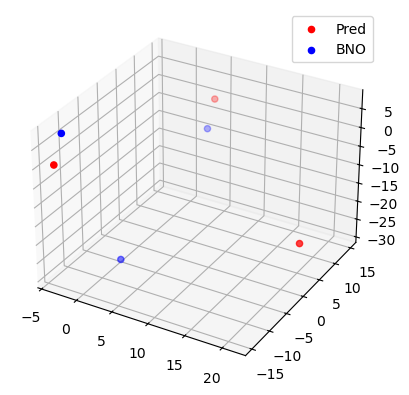

Saved animation to pred_bno_test_orientation_anim.mp4


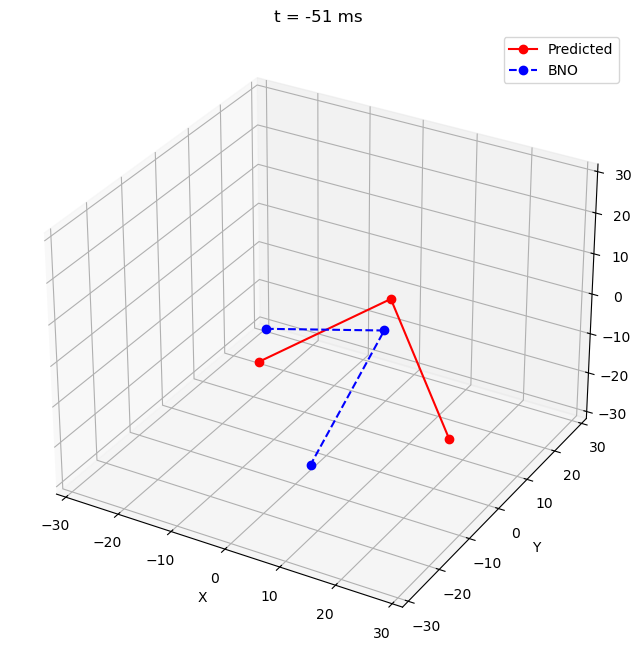

In [26]:
#!/usr/bin/env python3
import numpy as np
import pandas as pd
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from pathlib import Path

# --- Load filtered BNO data ---
bno_csv = "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_06/20241015pmcr2_17_13/MIR_Aligned/headOrientation_filtered.csv"
df_bno = pd.read_csv(bno_csv).rename(columns={'Time Stamp (ms)': 'time_ms'})
times = df_bno['time_ms'].to_numpy()
quats = df_bno[['qx','qy','qz','qw']].to_numpy()
rots = R.from_quat(quats)
bno_mats = rots.as_matrix()

print(f"BNO frames: {len(times)}")
print(f"BNO rotation mats shape: {bno_mats.shape}")

# --- Load prediction H5 and compute head frames ---
base_path = "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_06/20241015pmcr2_17_13"
aligned_dir = Path(base_path) / 'MIR_Aligned'
h5_paths = list(aligned_dir.glob('aligned_predictions_with_ca_and_dF_F_*.h5'))
if not h5_paths:
    raise FileNotFoundError(f"No .h5 files found in {aligned_dir}")
print("H5 files:", h5_paths)

df_pred = pd.read_hdf(str(h5_paths[0]), key='df')
print(f"Predicted frames: {len(df_pred)}")

# --- Compute head rotation matrices ---
def normalize(v):
    n = np.linalg.norm(v, axis=1, keepdims=True)
    return np.where(n < 1e-8, v, v / n)

R_heads = []
for _, row in df_pred.iterrows():
    earL  = row[['kp1_x','kp1_y','kp1_z']].to_numpy()
    earR  = row[['kp2_x','kp2_y','kp2_z']].to_numpy()
    snout = row[['kp3_x','kp3_y','kp3_z']].to_numpy()

    mid = (earL + earR) / 2.0
    x = normalize((snout - mid).reshape(1,3))[0]
    temp = (earR - earL).reshape(1,3)
    y = normalize((temp - np.dot(temp, x) * x).reshape(1,3))[0]
    z = np.cross(x, y)
    z = z / (np.linalg.norm(z) + 1e-8)
    R_heads.append(np.column_stack((x, y, z)))

R_heads = np.stack(R_heads)
print(f"Head rotation mats shape: {R_heads.shape}")

assert R_heads.shape == bno_mats.shape, \
    f"Frame mismatch: pred {R_heads.shape[0]}, bno {bno_mats.shape[0]}"

# --- Precompute relative rotations (correct order) ---
R0_bno = bno_mats[0]
R_bno_rel = np.einsum('ij,nkj->nki', np.linalg.inv(R0_bno), bno_mats)
R0_pred = R_heads[0]
R_pred_rel = np.einsum('ij,nkj->nki', np.linalg.inv(R0_pred), R_heads)

# --- Initial triangle vertices (relative) ---
earL0 = df_pred.iloc[0][['kp1_x','kp1_y','kp1_z']].to_numpy()
earR0 = df_pred.iloc[0][['kp2_x','kp2_y','kp2_z']].to_numpy()
sn0   = df_pred.iloc[0][['kp3_x','kp3_y','kp3_z']].to_numpy()
mid0  = (earL0 + earR0) / 2.0
verts0 = np.vstack([earL0-mid0, earR0-mid0, sn0-mid0])

# --- Frame 0 sanity check ---
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
p0 = verts0 @ R_pred_rel[0].T
b0 = verts0 @ R_bno_rel[0].T
print("Frame 0 pred pts:\n", p0)
print("Frame 0 bno pts:\n", b0)
ax.scatter(p0[:,0], p0[:,1], p0[:,2], c='r', label='Pred')
ax.scatter(b0[:,0], b0[:,1], b0[:,2], c='b', label='BNO')
ax.legend()
plt.show()

# --- Determine plot limits dynamically based on initial frame ---
all0 = np.vstack([p0, b0])
lim = np.max(np.abs(all0)) * 1.1

# --- Set up animation ---
fig2 = plt.figure(figsize=(8,8))
ax2 = fig2.add_subplot(111, projection='3d')
ax2.set_xlim(-lim, lim)
ax2.set_ylim(-lim, lim)
ax2.set_zlim(-lim, lim)
ax2.set_xlabel('X'); ax2.set_ylabel('Y'); ax2.set_zlabel('Z')
pred_line, = ax2.plot([], [], [], 'r-o', label='Predicted')
bno_line,  = ax2.plot([], [], [], 'b--o', label='BNO')
ax2.legend()

def update(i):
    p_pts = verts0 @ R_pred_rel[i].T
    b_pts = verts0 @ R_bno_rel[i].T

    pred_line.set_data(p_pts[:,0], p_pts[:,1])
    pred_line.set_3d_properties(p_pts[:,2])

    bno_line.set_data(b_pts[:,0], b_pts[:,1])
    bno_line.set_3d_properties(b_pts[:,2])

    ax2.set_title(f"t = {times[i]} ms")
    return pred_line, bno_line

ani = FuncAnimation(fig2, update, frames=len(times), interval=50, blit=False)

# --- Save animation (mp4, fallback to GIF) ---
# output_mp4 = "pred_bno_test_orientation_anim.mp4"
try:
    ani.save(output_mp4, writer='ffmpeg', fps=10)
    print("Saved animation to", output_mp4)
except Exception as e:
    print("ffmpeg save failed:", e)
    try:
        output_gif = "pred_bno_test_orientation_anim.gif"
        ani.save(output_gif, writer='pillow', fps=10)
        print("Saved animation to", output_gif)
    except Exception as e2:
        print("Pillow save failed:", e2)


BNO frames: 8896
BNO rotation mats shape: (8896, 3, 3)
H5 files: [PosixPath('/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_06/20241015pmcr2_17_13/MIR_Aligned/aligned_predictions_with_ca_and_dF_F_wnd1000_stp700_max15_diff3.5_pnrauto.h5')]
Predicted frames: 8896
Head rotation mats shape: (8896, 3, 3)
Frame 0 pred pts:
 [[ -3.71953889 -14.63203413   0.59609063]
 [  3.71953889  14.63203413  -0.59609063]
 [ 21.25044992   2.63730421 -20.55993497]]
Frame 0 bno pts:
 [[ -3.60296932 -12.7264707    7.30357939]
 [  3.60296932  12.7264707   -7.30357939]
 [  0.89323715  -6.64324364 -28.91915233]]


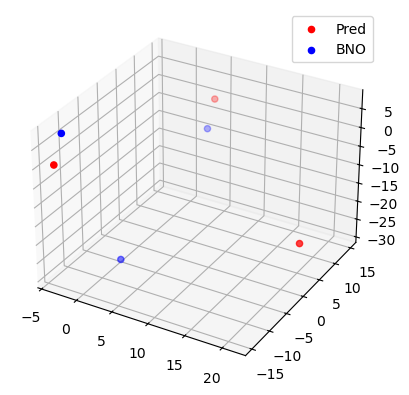

ffmpeg save failed: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '800x800', '-pix_fmt', 'rgba', '-framerate', '10', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', 'pred_bno_test_orientation_anim.mp4']' returned non-zero exit status 255.


In [ ]:
# a full scritp from teh start. not validated...

# #!/usr/bin/env python3
# import numpy as np
# import pandas as pd
# from scipy.spatial.transform import Rotation as R
# import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation
# from pathlib import Path

# # --- Load filtered BNO data ---
# bno_csv = "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_06/20241015pmcr2_17_13/MIR_Aligned/headOrientation_filtered.csv"
# df_bno = pd.read_csv(bno_csv).rename(columns={'Time Stamp (ms)': 'time_ms'})
# times = df_bno['time_ms'].to_numpy()
# quats = df_bno[['qx','qy','qz','qw']].to_numpy()
# rots = R.from_quat(quats)
# bno_mats = rots.as_matrix()

# print(f"BNO frames: {len(times)}")
# print(f"BNO rotation mats shape: {bno_mats.shape}")

# # --- Load prediction H5 and compute head frames ---
# base_path = "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_06/20241015pmcr2_17_13"
# aligned_dir = Path(base_path) / 'MIR_Aligned'
# h5_paths = list(aligned_dir.glob('aligned_predictions_with_ca_and_dF_F_*.h5'))
# if not h5_paths:
#     raise FileNotFoundError(f"No .h5 files found in {aligned_dir}")
# print("H5 files:", h5_paths)

# df_pred = pd.read_hdf(str(h5_paths[0]), key='df')
# print(f"Predicted frames: {len(df_pred)}")

# # --- Compute head rotation matrices ---
# def normalize(v):
#     n = np.linalg.norm(v, axis=1, keepdims=True)
#     return np.where(n < 1e-8, v, v / n)

# R_heads = []
# for _, row in df_pred.iterrows():
#     earL  = row[['kp1_x','kp1_y','kp1_z']].to_numpy()
#     earR  = row[['kp2_x','kp2_y','kp2_z']].to_numpy()
#     snout = row[['kp3_x','kp3_y','kp3_z']].to_numpy()

#     mid = (earL + earR) / 2.0
#     x = normalize((snout - mid).reshape(1,3))[0]
#     temp = (earR - earL).reshape(1,3)
#     y = normalize((temp - np.dot(temp, x) * x).reshape(1,3))[0]
#     z = np.cross(x, y)
#     z = z / (np.linalg.norm(z) + 1e-8)
#     R_heads.append(np.column_stack((x, y, z)))

# R_heads = np.stack(R_heads)
# print(f"Head rotation mats shape: {R_heads.shape}")
# assert R_heads.shape == bno_mats.shape, \
#     f"Frame mismatch: pred {R_heads.shape[0]}, bno {bno_mats.shape[0]}"

# # --- Precompute relative rotations ---
# R0_bno = bno_mats[0]
# R_bno_rel = np.einsum('ij,nkj->nki', np.linalg.inv(R0_bno), bno_mats)
# R0_pred = R_heads[0]
# R_pred_rel = np.einsum('ij,nkj->nki', np.linalg.inv(R0_pred), R_heads)

# # --- Initial triangle vertices (relative) ---
# earL0 = df_pred.iloc[0][['kp1_x','kp1_y','kp1_z']].to_numpy()
# earR0 = df_pred.iloc[0][['kp2_x','kp2_y','kp2_z']].to_numpy()
# sn0   = df_pred.iloc[0][['kp3_x','kp3_y','kp3_z']].to_numpy()
# mid0  = (earL0 + earR0) / 2.0
# verts0 = np.vstack([earL0-mid0, earR0-mid0, sn0-mid0])

# # --- Frame 0 sanity check ---
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# p0 = verts0 @ R_pred_rel[0].T
# b0 = verts0 @ R_bno_rel[0].T
# print("Frame 0 pred pts:\n", p0)
# print("Frame 0 bno pts:\n", b0)
# ax.scatter(p0[:,0], p0[:,1], p0[:,2], c='r', label='Pred')
# ax.scatter(b0[:,0], b0[:,1], b0[:,2], c='b', label='BNO')
# ax.legend()
# plt.show()

# # --- Determine plot limits dynamically based on initial frame ---
# all0 = np.vstack([p0, b0])
# lim = np.max(np.abs(all0)) * 1.1

# # --- Set up animation ---
# fig2 = plt.figure(figsize=(8,8))
# ax2 = fig2.add_subplot(111, projection='3d')
# ax2.set_xlim(-lim, lim)
# ax2.set_ylim(-lim, lim)
# ax2.set_zlim(-lim, lim)
# ax2.set_xlabel('X'); ax2.set_ylabel('Y'); ax2.set_zlabel('Z')
# pred_line, = ax2.plot([], [], [], 'r-o', label='Predicted')
# bno_line,  = ax2.plot([], [], [], 'b--o', label='BNO')
# ax2.legend()

# def update(i):
#     p_pts = verts0 @ R_pred_rel[i].T
#     b_pts = verts0 @ R_bno_rel[i].T

#     pred_line.set_data(p_pts[:,0], p_pts[:,1])
#     pred_line.set_3d_properties(p_pts[:,2])

#     bno_line.set_data(b_pts[:,0], b_pts[:,1])
#     bno_line.set_3d_properties(b_pts[:,2])

#     ax2.set_title(f"t = {times[i]} ms")
#     return pred_line, bno_line

# ani = FuncAnimation(fig2, update, frames=len(times), interval=50, blit=False)

# # --- Save animation (mp4, fallback to GIF) ---
# output_mp4 = "pred_bno_test_orientation_anim.mp4"
# try:
#     ani.save(output_mp4, writer='ffmpeg', fps=10)
#     print("Saved animation to", output_mp4)
# except Exception as e:
#     print("ffmpeg save failed:", e)
#     try:
#         output_gif = "pred_bno_test_orientation_anim.gif"
#         ani.save(output_gif, writer='pillow', fps=10)
#         print("Saved animation to", output_gif)
#     except Exception as e2:
#         print("Pillow save failed:", e2)

# # --- Evaluation: compute angular error between BNO and Predicted ---
# def rotation_error(R_ref, R_est):
#     # R_ref, R_est: shape (N,3,3)
#     # error rotation: R_err = R_ref.T @ R_est  for each frame
#     R_err = np.einsum('nij,njk->nik', np.transpose(R_ref, (0,2,1)), R_est)
#     # angle = arccos((trace(R_err)-1)/2)
#     angles = np.arccos(np.clip((np.trace(R_err, axis1=1, axis2=2)-1)/2, -1, 1))
#     return angles

# errors = rotation_error(R_bno_rel, R_pred_rel)
# errors_deg = np.degrees(errors)

# # summary stats
# print("Angular error (deg): mean={:.3f}, median={:.3f}, std={:.3f}".format(
#     errors_deg.mean(), np.median(errors_deg), errors_deg.std()))

# # save errors
# eval_df = pd.DataFrame({'time_ms': times, 'error_deg': errors_deg})
# # eval_df.to_csv("orientation_error.csv", index=False)
# print("Saved orientation_error.csv")

# # plot error over time
# plt.figure()
# plt.plot(times, errors_deg)
# plt.xlabel("Time (ms)")
# plt.ylabel("Angular error (°)")
# plt.title("Angular Error Over Time")
# plt.show()


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

def rotation_error(R_ref, R_est):
    R_err = np.einsum('nij,njk->nik', R_ref.transpose(0,2,1), R_est)
    ang   = np.arccos(np.clip((np.trace(R_err,axis1=1,axis2=2)-1)/2, -1,1))
    return np.degrees(ang)

# compute error
degs = rotation_error(R_bno_rel, R_pred_rel)
print(f"Error °: mean={degs.mean():.2f}, median={np.median(degs):.2f}, std={degs.std():.2f}")

# save + plot
eval_df = pd.DataFrame({'time_ms':times,'error_deg':degs})
eval_df.to_csv('orientation_error.csv',index=False)
print('Saved orientation_error.csv')

plt.figure(); plt.plot(times,degs); plt.xlabel('ms'); plt.ylabel('Error (°)'); plt.title('Angular Error Over Time'); plt.show()

NameError: name 'R_bno_rel' is not defined